In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


In [19]:
df = pd.read_parquet('/Users/dianaterraza/Desktop/portfolio_project/data/processed_data.parquet')

## STEP 1: Data Preparation and Feature Engineering

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2000-01-03 to 2019-12-31
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SGD_USD  5217 non-null   float64
 1   CNY_USD  5217 non-null   float64
dtypes: float64(2)
memory usage: 122.3 KB


In [22]:
# Feature engineering
for i in range(1, 13):  # 12 months of lag
    df[f'lag_{i}'] = df['SGD_USD'].shift(i)

df['rolling_mean_3'] = df['SGD_USD'].rolling(3).mean()
df['rolling_std_3'] = df['SGD_USD'].rolling(3).std()

df.dropna(inplace=True)

### Check for stationarity

In [23]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['SGD_USD'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])  # < 0.05 means stationary

ADF Statistic: -1.1770450813337892
p-value: 0.6833915818559266


##  STEP 2: Model Selection – ARIMA & SARIMA

### ARIMA MODELING

In [24]:
# Train/Test split
train = df.iloc[:-12]['SGD_USD']
test = df.iloc[-12:]['SGD_USD']

# Fit ARIMA
model_arima = ARIMA(train, order=(1,1,1))  # Tune this later
results_arima = model_arima.fit()
forecast_arima = results_arima.forecast(steps=12)

# Evaluation
print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, forecast_arima)))


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


ARIMA RMSE: 0.0037946364650671594


### SARIMA MODELING

In [25]:
# Seasonal period = 12 for monthly data
model_sarima = SARIMAX(train, 
                       order=(1,1,1), 
                       seasonal_order=(1,1,1,12), 
                       enforce_stationarity=False,
                       enforce_invertibility=False)

results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.forecast(steps=12)

print("SARIMA RMSE:", np.sqrt(mean_squared_error(test, forecast_sarima)))


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.79298D+00    |proj g|=  6.37255D+01

At iterate    5    f= -3.85569D+00    |proj g|=  1.06793D+00

At iterate   10    f= -3.86119D+00    |proj g|=  2.47812D+01

At iterate   15    f= -3.90702D+00    |proj g|=  2.18355D+01

At iterate   20    f= -3.91628D+00    |proj g|=  1.72392D-01

At iterate   25    f= -3.91628D+00    |proj g|=  5.53482D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     90      2     0     0   3.035D-01  -3.916D+00
  F =  -3.9163002157672420     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA RMSE: 0.0034110487221542573


## STEP 3: Machine Learning Benchmark – XGBoost

In [26]:
# XGBoost
features = df.drop(columns=['SGD_USD'])
target = df['SGD_USD']

X_train, X_test = features.iloc[:-12], features.iloc[-12:]
y_train, y_test = target.iloc[:-12], target.iloc[-12:]

xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

print("XGBoost MAE:", mean_absolute_error(y_test, pred_xgb))


XGBoost MAE: 0.0009992893218994103


## STEP 4: Hyperparameter Optimization

In [31]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)


Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


### VISUAL COMPARISON

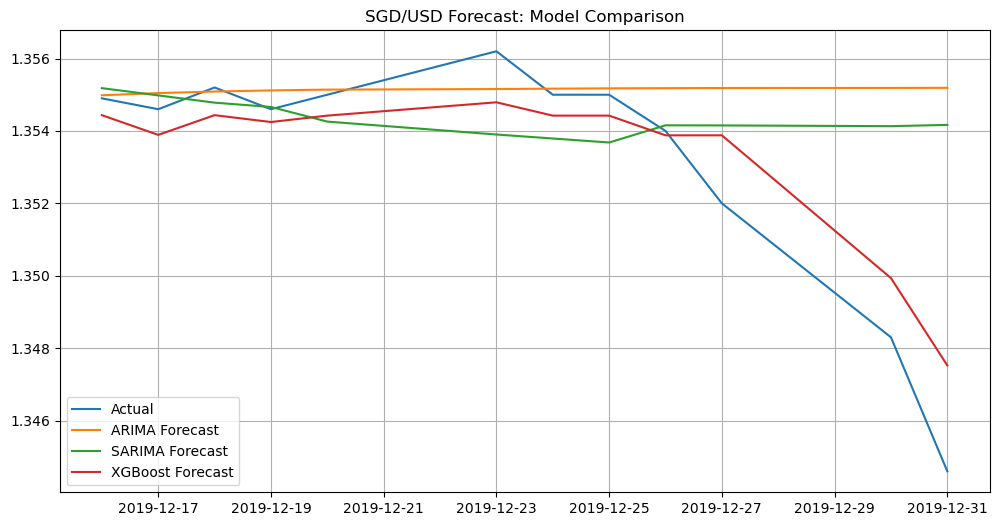

In [28]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast')
plt.plot(test.index, pred_xgb, label='XGBoost Forecast')
plt.title("SGD/USD Forecast: Model Comparison")
plt.legend()
plt.grid(True)
plt.show()
